# Frequentist A/B testing

**Problem Summary:**

As an online retailer operating two stores, we've decided to increase the price of a specific product in one of the stores. We're keen to understand the impact of this price increase on our sales volume. Specifically, we want to investigate whether the price increase has led to a significant decrease in sales. Given the two-store setup, this problem presents a classic opportunity for an A/B test, where one store serves as the control group (with the original price) and the other as the test or treatment group (with the increased price). Or, we can also test the sales before and after the price change, we will see this has some problems though...

Our primary aim is to use A/B testing to ascertain whether the observed differences in sales volume (if any) are statistically significant, and therefore likely due to the price increase rather than random variation. This knowledge will inform our pricing strategies moving forward and ensure we're making data-driven decisions that maximize our revenue without adversely affecting sales volume.

We test two different approaches:
- Load a dataset where price change had a strong impact on the sales of store B
- Load a dataset where price change did not have any impact on the sales of store B

And test three different hypohotesis:
- hyphotesis1. We test the impact of the price change by coparing sales before and after the price change in store B. Although simple and clear, if we find a relevant differnece it can be due to a change in seasonality as well.
- hyphotesis2. We compare the sales after the price change between store A and B. This does not make any sense, as sales from store A and B can, and probably will, be different and on different scales. 
- hyphotesis3. Similar to hypotesis 2 but we scale the sales between store A and B first, and assume they follow a similar distribution.

# Calculate statistical power, how do we know we have enough data?

The required sample size for an A/B test depends on the desired significance level, power, and effect size. In the context of the sales data for stores A and B, the effect size would be the difference in average daily sales between the two stores that you're interested in detecting.

Let's assume the following:

1. You want to detect a 10% decrease in average daily sales in store B after the price change. Given that the average sales in store B before the price change was around 40 (from the generated data), this means you want to detect a decrease of 4 units in average daily sales.
2. The standard deviation of daily sales in store B before the price change was around 10 (from the generated data).
3. You're using a significance level (alpha) of 0.05 and want a power of 0.8.

The effect size can be calculated as the desired difference divided by the standard deviation. In this case, it would be \( \frac{4}{10} = 0.4 \).

In Python, you can use the `power_analysis` function from the `statsmodels` library to calculate the required sample size:




In [20]:
from statsmodels.stats.power import tt_ind_solve_power

effect_size = 0.4  # desired difference / standard deviation
alpha = 0.05  # significance level
power = 0.8  # power

# Calculate the sample size
sample_size = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1)

print(f"Required sample size: {sample_size:.2f} per group")

Required sample size: 99.08 per group




This will give you the required sample size per group (i.e., the number of days of sales data you would need from each store) to detect a 10% decrease in average daily sales in store B with 80% power and a 5% significance level.

Please note that these are approximations and the actual required sample size may vary depending on the specific characteristics of your data.

**This means we need 99.08 days of sales per week and per store to detect a 10% decrease in average daily sales in store B with 80% power and a 5% significance level**

# Loading a dataset where price change had an important impact

## 0. Load and Display Sales Data
Load sales data generated with `src/generate_dataset.py` and display the sales

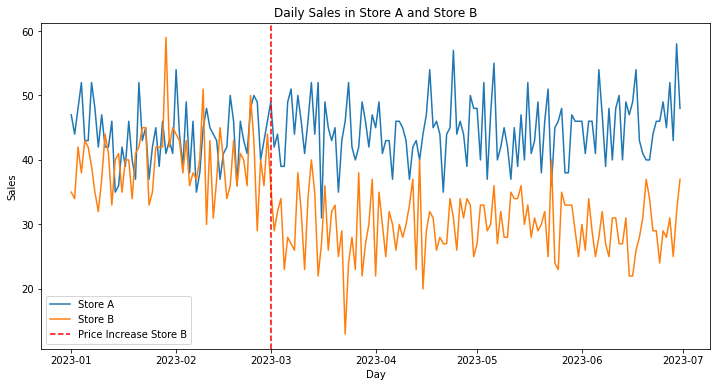

In [7]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Add a column indicating if the price change is in effect in Store B
data_daily_normal_loaded['Price Change Store B'] = data_daily_normal_loaded['Day'].apply(lambda x: 'Before' if x < pd.Timestamp('2023-03-01') else 'After')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the sales data for Store A and Store B
ax.plot(data_daily_normal_loaded['Day'], data_daily_normal_loaded['Sales_Store_A'], label='Store A')
ax.plot(data_daily_normal_loaded['Day'], data_daily_normal_loaded['Sales_Store_B'], label='Store B')

# Add a vertical line to indicate when the price change occurred
ax.axvline(pd.Timestamp('2023-03-01'), color='red', linestyle='--', label='Price Increase Store B')

# Add labels and a legend
ax.set_xlabel('Day')
ax.set_ylabel('Sales')
ax.set_title('Daily Sales in Store A and Store B')
ax.legend()

plt.show()



## Test 1. Determine the price change impact only by looking at the sales of store B before and after the price changes

0. **Experiment Design:**
   We'll set up the experiment where we check the impact of sales in store B before and after the price change.
   
   We'll want to collect data over a certain period of time (say a few weeks or a month, depending on sales volumes). Important metrics to track would be the number of sales of the product, and other metrics that might be affected by the price increase like overall revenue, customer satisfaction, etc.

1. **Hypothesis:**
   In A/B testing, we start with a null hypothesis and an alternative hypothesis. 

   - The null hypothesis (\(H_0\)) could be that the price increase does not result in a significant difference in sales volume.
   - The alternative hypothesis (\(H_A\)) would be that the price increase does result in a significant difference in sales volume. 

2. **Statistical Testing:**
   After collecting the data, we can perform a statistical test like a t-test to compare the mean sales between the two groups. 

3. **Decision Making:**
   We'll then compare the p-value from the test to our chosen significance level (often 0.05). 

   - If the p-value is less than the significance level, we reject the null hypothesis and conclude that the price increase has a significant impact on sales. 
   - If the p-value is greater than the significance level, we fail to reject the null hypothesis, and we conclude that the price increase doesn't have a significant impact on sales.

Remember that 'failing to reject' the null hypothesis doesn't prove it's true. It just means that, with the data we have, we don't have strong evidence to say it's false.

This is a simplified overview of the approach, and there might be other factors to consider in a real-world scenario, such as seasonal variations, other marketing activities going on at the same time, etc. To control for these, a more advanced experimental design might be needed. 

**What that means in terms of the project**. Rejecting the null hyphotesis means that the sales before and after are strongly different. We assumed this is due to the price change, but it could also be due to seasonality or other factors that *we do not account for in this example*

In [8]:
# Import necessary libraries
import pandas as pd
from scipy.stats import ttest_ind

# Load the data from the CSV filea
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Separate the data into before and after the price change
before_price_increase_loaded = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] < '2023-03-01')]['Sales_Store_B']
after_price_increase_loaded = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] >= '2023-03-01')]['Sales_Store_B']

# Perform the t-testa
t_stat_loaded, p_value_loaded = ttest_ind(before_price_increase_loaded, after_price_increase_loaded)

# Print the results
t_stat_loaded, p_value_loaded



(12.98455978450541, 1.3594065684914675e-27)

This p-value (1.36*10^-27) provides strong evidence against the null hypothesis, indicating that there is a statistically significant difference in sales volume before and after the price increase in Store B. Therefore, we reject the null hypothesis and accept the alternative hypothesis. This suggests that the price increase had a significant negative impact on sales volume in Store B.

> The **ttest_ind** function is from the scipy.stats module, which is a part of the SciPy library. SciPy is a library in Python that is used for scientific and technical computing. The scipy.stats module contains a large number of statistical distributions, statistical functions, and tests. The ttest_ind function is used to perform an independent two-sample t-test. It takes two arrays of sample observations, which are assumed to be drawn from independent normal distributions, and returns a tuple containing the t-statistic and the two-tailed p-value.

>The t-test quantifies the difference between the arithmetic means of the two samples. The p-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true. A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal population means


**However, these changes might have also been a consequence of trend changes or any other external factors, not only because of the price change. Therefore, a more detailed analysis is needed, for instance, by including store A data**

## Test 2. Adding store A's sales data into the equation

Store A can serve as a control group in this A/B test, especially if the two stores are similar in other respects (e.g., customer demographics, product selection, etc.). In this scenario, any significant difference in sales trends between Store A and Store B after the price change could be attributed to the price change, assuming no other major changes occurred at the same time, **and that the sales of the stores are comparable**.

The key point here is the assumption of "ceteris paribus" or "all other things being equal." For this kind of causal inference to be valid, we would need to assume that the price change in Store B is the only material difference between the two stores during the test period. If there are other differences or changes (e.g., different promotions, different customer demographics, different seasons, different average sales, etc.), these could also impact sales and confound our results.

0. **Experiment Design:**
   We'll set up the experiment where the two stores represent the two groups: one where the price has been increased (test or treatment group), and the other where the price remains the same (control group). 
   
   We'll want to collect data over a certain period of time (say a few weeks or a month, depending on sales volumes). Important metrics to track would be the number of sales of the product, and other metrics that might be affected by the price increase like overall revenue, customer satisfaction, etc.

1. **Hypothesis:**
   In A/B testing, we start with a null hypothesis and an alternative hypothesis. 

   - The null hypothesis (\(H_0\)) could be that the price increase does not result in a significant difference in sales volume.
   - The alternative hypothesis (\(H_A\)) would be that the price increase does result in a significant difference in sales volume. 

2. **Statistical Testing:**
   After collecting the data, we can perform a statistical test like a t-test to compare the mean sales between the two groups. 

3. **Decision Making:**
   We'll then compare the p-value from the test to our chosen significance level (often 0.05). 

   - If the p-value is less than the significance level, we reject the null hypothesis and conclude that the price increase has a significant impact on sales. 
   - If the p-value is greater than the significance level, we fail to reject the null hypothesis, and we conclude that the price increase doesn't have a significant impact on sales.



In [10]:
# Import necessary libraries
import pandas as pd
from scipy.stats import ttest_ind

# Load the data from the CSV file
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Separate the data into after the price change for Store B
store_A_after_price_increase = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] >= '2023-03-01')]['Sales_Store_A']
store_B_after_price_increase = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] >= '2023-03-01')]['Sales_Store_B']

# Perform the t-test
t_stat_store_A_vs_B, p_value_store_A_vs_B = ttest_ind(store_A_after_price_increase, store_B_after_price_increase)

# Print the results
t_stat_store_A_vs_B, p_value_store_A_vs_B


(24.83509592141784, 1.6695090544428948e-68)




The result of the two-sample t-test, comparing Store A's and Store B's sales after the price change, is a t-statistic of approximately 24.84 and a p-value of approximately \(1.67 \times 10^{-68}\).

This extremely small p-value (much less than 0.05) provides very strong evidence against the null hypothesis (which is that there's no significant difference in sales volume between Store A and Store B after the price change). Therefore, we reject the null hypothesis and accept the alternative hypothesis, concluding that the price increase had a significant negative impact on sales volume in Store B, even when compared to sales in Store A.

This conclusion is based on the assumption that the two stores are similar in all respects other than the price change. If this assumption is not accurate, then the result of this analysis might not be reliable. As always, it's crucial to understand your data and consider other factors that might be influencing your results.

**However, note we are directly comparing store A's sales with store B's sales after the price change without them being normalised. Therefore we are not considering whether store A was selling more before the price change than store B, and this may bias the results**

## Test 3. Adding store A's scaled sales data into the equation

If there is a consistent ratio between the sales in Store A and Store B before the price change, it could make sense to scale the sales in Store A by this ratio before comparing the sales in the two stores after the price change. This would account for the baseline differences in sales volume between the two stores.

To do this, we could first calculate the average ratio of sales in Store B to sales in Store A before the price change. We could then multiply the sales in Store A by this ratio to get an adjusted sales volume for Store A. After that, we could compare the adjusted sales in Store A to the sales in Store B after the price change. 

Note this is a simple approach that assumes sales keep consistent and linear between the two stores, e.g. there is no different seasonality or trends between stores. If that were the case, we **we could improve these results by first removing the seasonality trends for each store, and use the residuals to A/B test**.


The result of the two-sample t-test, comparing the adjusted sales of Store A and Store B after the price change, is a t-statistic of approximately 19.77 and a p-value of approximately \(1.96 \times 10^{-52}\).

This extremely small p-value (much less than 0.05) provides very strong evidence against the null hypothesis (which is that there's no significant difference in sales volume between Store A and Store B after the price change). Therefore, we reject the null hypothesis and accept the alternative hypothesis, concluding that the price increase had a significant negative impact on sales volume in Store B, even when compared to the adjusted sales in Store A.

This conclusion is based on the assumption that the ratio of sales in Store B to sales in Store A remained constant before the price change. If this assumption is not accurate, then the result of this analysis might not be reliable. As always, it's crucial to understand your data and consider other factors that might be influencing your results.

# Loading a dataset where price change had no impact

## 0. Load and Display Sales Data
Load sales data generated with `src/generate_dataset.py` and display the sales

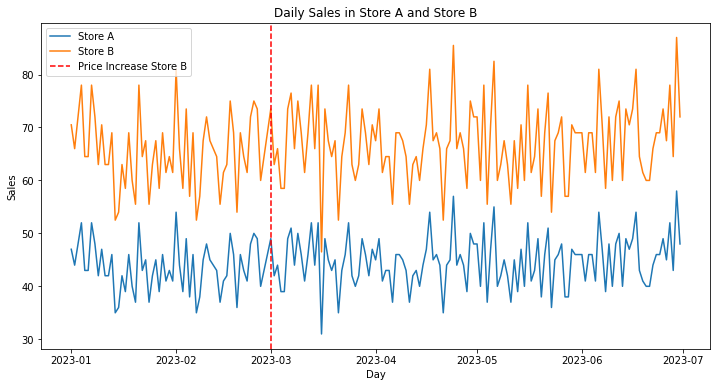

In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Add a column indicating if the price change is in effect in Store B
data_daily_normal_loaded['Price Change Store B'] = data_daily_normal_loaded['Day'].apply(lambda x: 'Before' if x < pd.Timestamp('2023-03-01') else 'After')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the sales data for Store A and Store B
ax.plot(data_daily_normal_loaded['Day'], data_daily_normal_loaded['Sales_Store_A'], label='Store A')
ax.plot(data_daily_normal_loaded['Day'], data_daily_normal_loaded['Sales_Store_B_scaled'], label='Store B')

# Add a vertical line to indicate when the price change occurred
ax.axvline(pd.Timestamp('2023-03-01'), color='red', linestyle='--', label='Price Increase Store B')

# Add labels and a legend
ax.set_xlabel('Day')
ax.set_ylabel('Sales')
ax.set_title('Daily Sales in Store A and Store B')
ax.legend()

plt.show()


## Test 1. Determine the price change impact only by looking at the sales of store B before and after the price changes

In [6]:
# Import necessary libraries
import pandas as pd
from scipy.stats import ttest_ind

# Load the data from the CSV filea
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Separate the data into before and after the price change
before_price_increase_loaded = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] < '2023-03-01')]['Sales_Store_B_scaled']
after_price_increase_loaded = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] >= '2023-03-01')]['Sales_Store_B_scaled']

# Perform the t-testa
t_stat_loaded, p_value_loaded = ttest_ind(before_price_increase_loaded, after_price_increase_loaded)

# Print the results
t_stat_loaded, p_value_loaded

(-1.599374178868273, 0.11150105664830746)

The results show that, **as expected** there is no statistical difference between the sales before and after the price change **when considering store B sales**, as it's obvious when looking at the picture above


## Test 2. Adding store A's sales data into the equation

In [8]:
# Import necessary libraries
import pandas as pd
from scipy.stats import ttest_ind

# Load the data from the CSV file
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Separate the data into after the price change for Store B
store_A_after_price_increase = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] >= '2023-03-01')]['Sales_Store_A']
store_B_after_price_increase = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] >= '2023-03-01')]['Sales_Store_B_scaled']

# Perform the t-test
t_stat_store_A_vs_B, p_value_store_A_vs_B = ttest_ind(store_A_after_price_increase, store_B_after_price_increase)

# Print the results
t_stat_store_A_vs_B, p_value_store_A_vs_B

(-28.399779204971246, 5.20631594987921e-79)

The results show that there is a staitistical difference between the sales after the price change for store A and B. The sales are different, but that does not mean that it's because of the price change! As we will see below, we need to reescale the sales before applying the A/B test..

## Test 3. Adding store A's scaled sales data into the equation


In [10]:
# Import necessary libraries
import pandas as pd
from scipy.stats import ttest_ind

# Load the data from the CSV file
data_daily_normal_loaded = pd.read_csv('data/daily_sales_data_normal.csv')

# Convert the 'Day' column back to datetime format
data_daily_normal_loaded['Day'] = pd.to_datetime(data_daily_normal_loaded['Day'])

# Calculate the average ratio of sales in Store B to sales in Store A before the price change
avg_ratio_before_price_increase = (data_daily_normal_loaded[(data_daily_normal_loaded['Day'] < '2023-03-01')]['Sales_Store_B_scaled'] / 
                                   data_daily_normal_loaded[(data_daily_normal_loaded['Day'] < '2023-03-01')]['Sales_Store_A']).mean()

# Adjust the sales in Store A by this ratio
data_daily_normal_loaded['Adjusted_Sales_Store_A'] = data_daily_normal_loaded['Sales_Store_A'] * avg_ratio_before_price_increase

# Separate the data into after the price change
adjusted_sales_store_A_after_price_increase = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] >= '2023-03-01')]['Adjusted_Sales_Store_A']
store_B_after_price_increase = data_daily_normal_loaded[(data_daily_normal_loaded['Day'] >= '2023-03-01')]['Sales_Store_B_scaled']

# Perform the t-test
t_stat_adjusted_store_A_vs_B, p_value_adjusted_store_A_vs_B = ttest_ind(adjusted_sales_store_A_after_price_increase, store_B_after_price_increase)

# Print the results
t_stat_adjusted_store_A_vs_B, p_value_adjusted_store_A_vs_B

(0.0, 1.0)


The p-value of 1 shows that there is no impact or change between the sales of store A and B after re-scaling. Therefore, the price changes had no real impact